# First EDA

In [2]:
import pandas as pd
import numpy as np
from trackml.dataset import load_event
import seaborn as sns
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

In [2]:
path2data = '/home/alepfu/Desktop/dataset/train_100_events/'
event_id = 'event000001000'
hits, cells, particles, truth = load_event(path2data + event_id)

hits_truth = pd.merge(truth, pd.DataFrame(hits), on = ['hit_id']).loc[:,["hit_id", "particle_id", "x", "y", "z"]]
hits_truth['r'] = hits_truth.apply(lambda hit: np.sqrt(hit['x']**2 + hit['y']**2), axis=1)

### Mean nhits

Mean nhits = 8.42412134061812


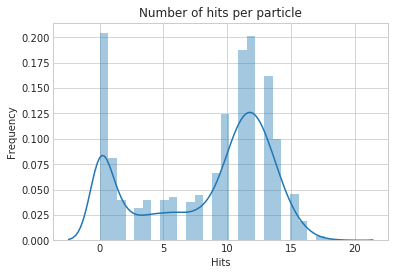

In [3]:
%matplotlib inline

print('Mean nhits = ' + str(particles['nhits'].mean() ))

ax = sns.distplot(particles['nhits']);
ax.set_ylabel('Frequency')
ax.set_xlabel('Hits')
ax.set_title('Number of hits per particle')
plt.show()


### Not so good trajectories
e.g. trajectories with <=6 hits are not interesting, so we want to know how much of them are in the dataset.

In [4]:
high_nhits = len(particles[particles['nhits'] > 6])
print('Particles with high number of hits = ' + str(round(100.0 * high_nhits / len(particles.index), 2)) + "%")
low_nhits= len(particles[particles['nhits'] <= 6])
print('Particles with low number of hits = ' + str(round(100.0 * low_nhits / len(particles.index), 2)) + "%")

Particles with high number of hits = 67.53%
Particles with low number of hits = 32.47%


### Average number of particle productions within a spatial bin

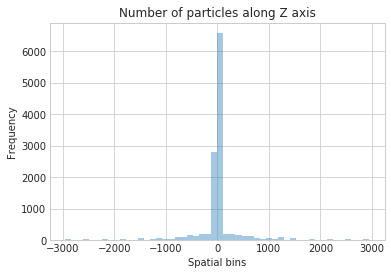

In [5]:
%matplotlib inline

vz = particles['vz']
ax = sns.distplot(vz, kde=False);
ax.set_ylabel('Frequency')
ax.set_xlabel('Spatial bins')
ax.set_title('Number of particles along Z axis')
plt.show()

### Travel distances Z axis

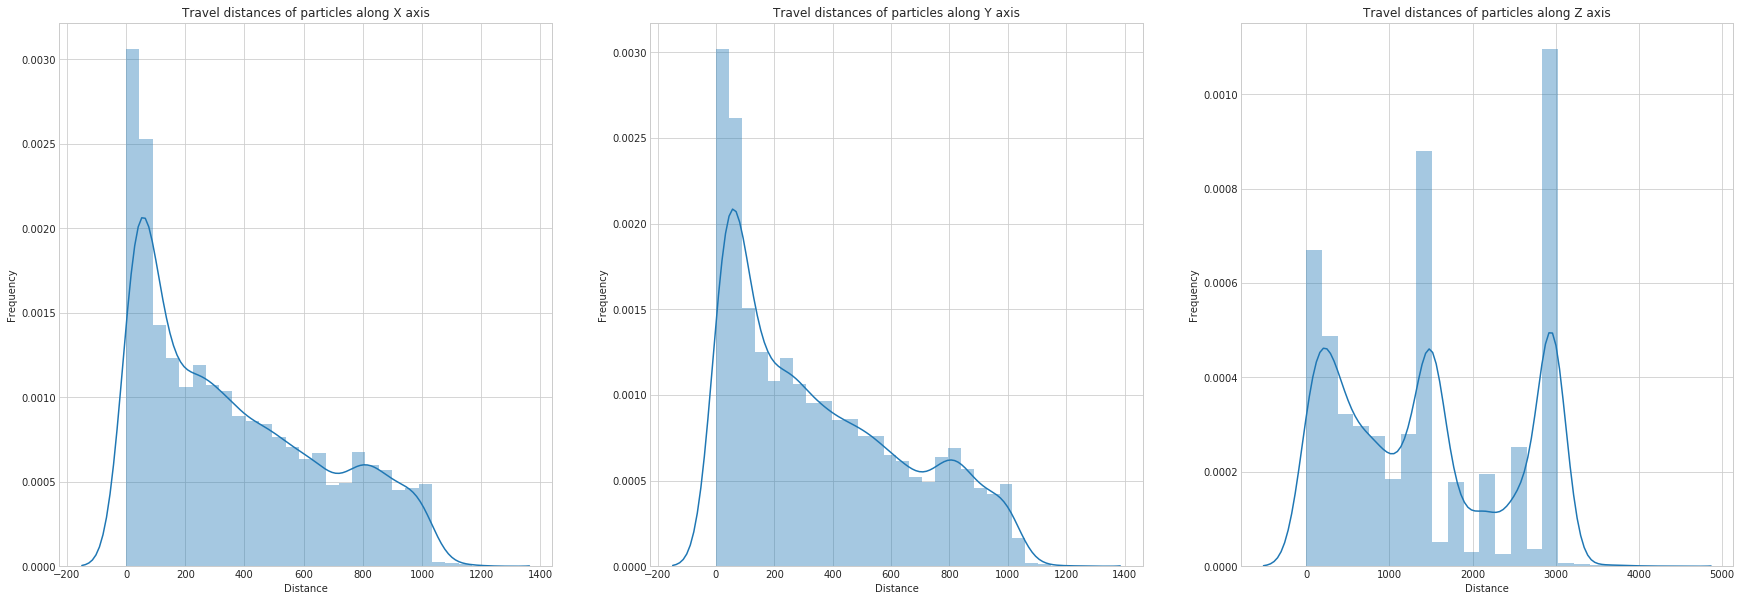

In [6]:
%matplotlib inline

merge = pd.merge(pd.merge(truth, pd.DataFrame(hits), on = ['hit_id']), pd.DataFrame(particles), on = ['particle_id'])
merge = merge.loc[:,["hit_id", "particle_id", "x", "vx", "y", "vy", "z", "vz"]]
merge['dx'] = merge.apply(lambda hit: abs(hit['x'] - hit['vx']), axis=1)
merge['dy'] = merge.apply(lambda hit: abs(hit['y'] - hit['vy']), axis=1)
merge['dz'] = merge.apply(lambda hit: abs(hit['z'] - hit['vz']), axis=1)
group = merge.groupby(['particle_id']).agg({'dx':'max', 'dy':'max', 'dz':'max'}).reset_index()

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
ax = sns.distplot(group['dx']);
ax.set_ylabel('Frequency')
ax.set_xlabel('Distance')
ax.set_title('Travel distances of particles along X axis')

plt.subplot(1,3,2)
ax = sns.distplot(group['dy']);
ax.set_ylabel('Frequency')
ax.set_xlabel('Distance')
ax.set_title('Travel distances of particles along Y axis')

plt.subplot(1,3,3)
ax = sns.distplot(group['dz']);
ax.set_ylabel('Frequency')
ax.set_xlabel('Distance')
ax.set_title('Travel distances of particles along Z axis')

plt.show()

### Layers, volumes and modules

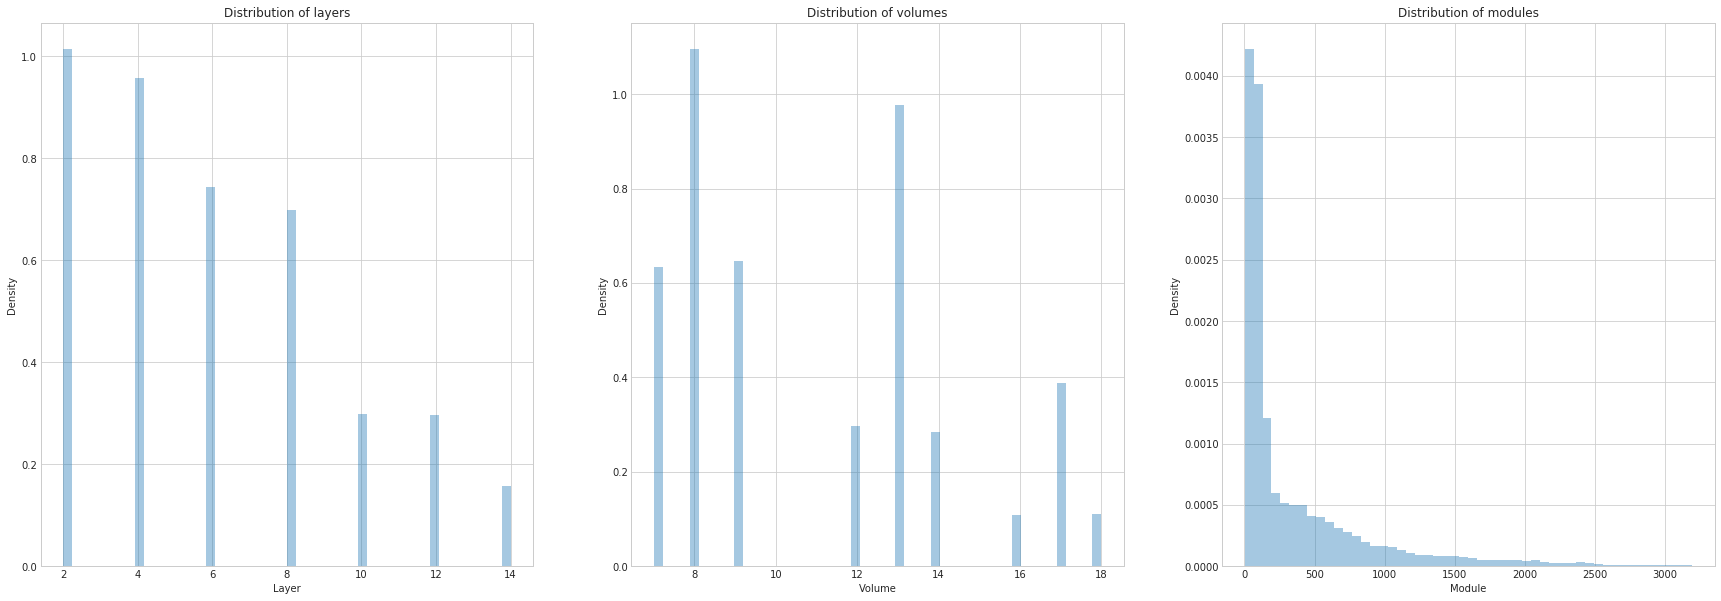

In [7]:
%matplotlib inline

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
ax = sns.distplot(hits['layer_id'], hist=True, kde=False, norm_hist=True);
ax.set_ylabel('Density')
ax.set_xlabel('Layer')
ax.set_title('Distribution of layers')

plt.subplot(1,3,2)
ax = sns.distplot(hits['volume_id'], hist=True, kde=False, norm_hist=True);
ax.set_ylabel('Density')
ax.set_xlabel('Volume')
ax.set_title('Distribution of volumes')

plt.subplot(1,3,3)
ax = sns.distplot(hits['module_id'], hist=True, kde=False, norm_hist=True);
ax.set_ylabel('Density')
ax.set_xlabel('Module')
ax.set_title('Distribution of modules')
plt.show()

### Number of layers per particle

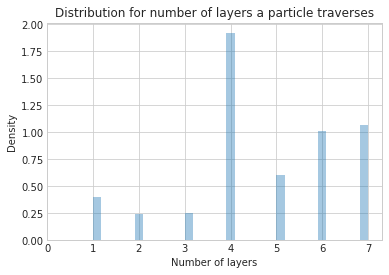

In [8]:
%matplotlib inline

merge = pd.merge(truth, pd.DataFrame(hits), on = ['hit_id'])
grouped = merge.groupby(['particle_id', 'layer_id']).size()
grouped = grouped.groupby(['particle_id']).size().reset_index(name='number_of_layers')
ax = sns.distplot(grouped['number_of_layers'], hist=True, kde=False, norm_hist=True);
ax.set_ylabel('Density')
ax.set_xlabel('Number of layers')
ax.set_title('Distribution for number of layers a particle traverses')
ax.set_xticks(np.arange(0, 8, 1))
plt.show()

## Exploring angles

We want to investigate angles of hits and tajectories:
* get the distribution of all hit angles
* collect the angles for each trajectory
* get the distribution of angle ranges for trajectories

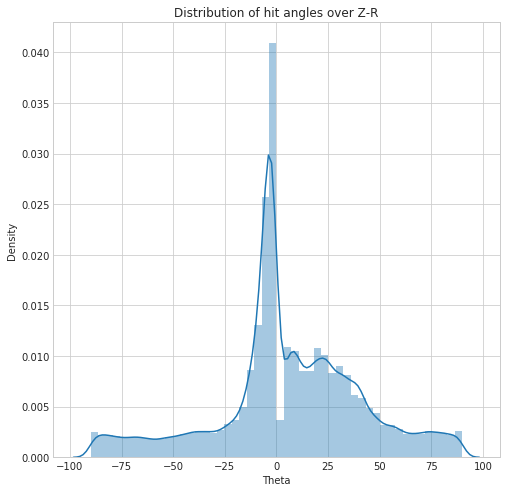

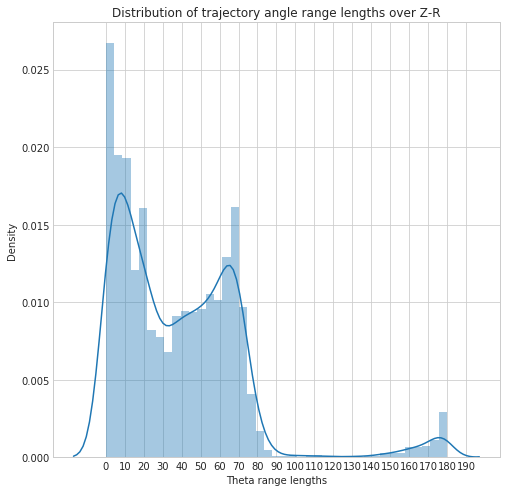

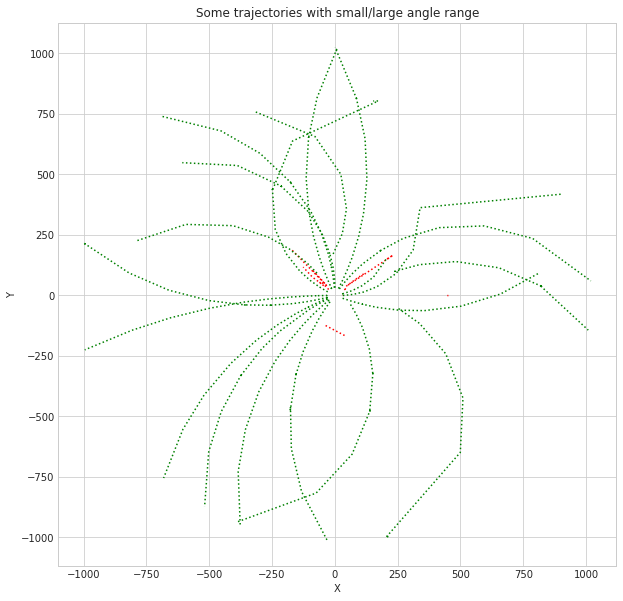

In [81]:
merge = pd.merge(pd.merge(truth, pd.DataFrame(hits), on = ['hit_id']), pd.DataFrame(particles), on = ['particle_id'])
merge = merge.loc[:,["hit_id", "particle_id", "x", "y", "z"]]
merge['r'] = hits_truth.apply(lambda hit: np.sqrt(hit.x**2 + hit.y**2), axis=1)

merge['theta'] = merge.apply(lambda hit: np.arctan(hit.r / hit.z) * 180/np.pi, axis=1)


plt.figure(figsize=(8,8))
ax = sns.distplot(merge['theta']);
ax.set_ylabel('Density')
ax.set_xlabel('Theta')
ax.set_title('Distribution of hit angles over Z-R')
plt.show()

plt.figure(figsize=(8,8))
group = merge.groupby('particle_id').agg({'theta':['min','max']}).reset_index()
group.columns = ["_".join(x) for x in group.columns.ravel()]
group.rename(columns={'particle_id_': 'particle_id'}, inplace=True)
group['theta_range_len'] = group.apply(lambda p: abs(p.theta_min - p.theta_max), axis=1)
ax = sns.distplot(group['theta_range_len']);
ax.set_ylabel('Density')
ax.set_xlabel('Theta range lengths')
ax.set_title('Distribution of trajectory angle range lengths over Z-R')
ax.set_xticks(np.arange(0, 200, 10))
plt.show()

N_sample = 20

small_theta = group[group['theta_range_len'] < 5.0].sample(N_sample)
large_theta = group[(group['theta_range_len'] > 170.0) & (group['theta_range_len'] < 180.0)].sample(N_sample)

fig = plt.figure(figsize=(10,10))

for item in small_theta['particle_id']:
    p = hits_truth.loc[hits_truth['particle_id'].isin([item])]
    plt.plot(p.x, p.y, ":", c='red', label='small theta range')
    
for item in large_theta['particle_id']:
    p = hits_truth.loc[hits_truth['particle_id'].isin([item])]
    plt.plot(p.x, p.y, ":", c='green', label='large theta range')
    
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Some trajectories with small/large angle range")
plt.show()

### Exploring distances between hits
e.g. calc all the distances between the hits of the trajectories and show distribution over layers

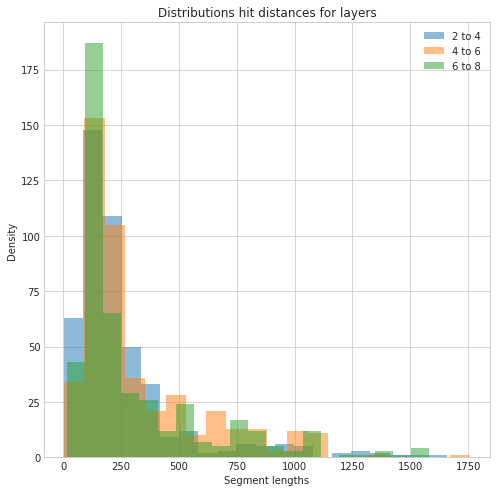

In [168]:
df = pd.merge(pd.merge(truth, pd.DataFrame(hits), on = ['hit_id']), pd.DataFrame(particles), on = ['particle_id'])
df = df.loc[:,["hit_id", "particle_id", "x", "y", "z", "nhits", 'layer_id']]

N_sample = 500

layer_dists = {'4':[], '6':[], '8':[], '10':[], '12':[], '14':[]}

for par in np.unique(df.sample(N_sample).particle_id.values):
    traj = df[df.particle_id == par]

    traj = traj.groupby(['layer_id']).agg({'x': 'mean', 'y': 'mean', 'z': 'mean', 'particle_id':'last'}).reset_index()

    for index, row in traj.iterrows():
        if index != 0:
            v1 = (traj.iloc[index-1])[['x','y','z']].values
            v2 = (traj.iloc[index])[['x','y','z']].values
            dist = np.linalg.norm(v1 - v2)
            layer_dists[str(int(row.layer_id))].append(dist)

plt.figure(figsize=(8,8))
plt.hist(layer_dists['4'], 20, alpha=0.5, label='2 to 4')
plt.hist(layer_dists['6'], 20, alpha=0.5, label='4 to 6')
plt.hist(layer_dists['8'], 20, alpha=0.5, label='6 to 8')
plt.legend(loc='upper right')
plt.ylabel('Density')
plt.xlabel('Segment lengths')
plt.title('Distributions hit distances for layers')
